### 1. iris dataset

iris dataset 은 가장 기초적이면서도 오래되었고 쉽고 간단한 머신러닝, 데이터분석의 고전이라고 할 수 있습니다.   


petal(꽃잎)과 sepal(꽃받침)의 길이/너비를 **Feature(독립변수, X)**로 사용하여,  
(setosa, versicolor, virginica 중) 어떤 종의 iris 인지  **Label(종속변수, Y)**를 예측하는 머신러닝에 사용되는 dataset입니다.

<img src = "https://miro.medium.com/max/1100/0*SHhnoaaIm36pc1bd" width = "800">

In [3]:
import torch
import pandas as pd
from sklearn import datasets
import seaborn as sns
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F

In [4]:
dataset = sns.load_dataset('iris') # seaborn(sns) 패키지에 '이미 내장'되어 있는 데이터셋이기 때문에 이런 방식의 load가 가능! 
                                # 자신만의 데이터를 불러올 때는 다른 방법을 써야합니다.
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [5]:
species = list(dataset["species"].unique())
dataset["species_index"] = dataset["species"].apply(species.index)
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_index
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


In [7]:
import plotly
import plotly.express as px

fig = px.scatter_3d(dataset[["sepal_length","sepal_width","petal_length","petal_width","species"]],
                    x = 'sepal_length',
                    y = 'sepal_width',
                    z = 'petal_width',
                    size = 'petal_length',
                    color = 'species',
                    opacity = 0.7)

fig.update_layout(margin = dict(l=0, r=0, b=0, t=0))

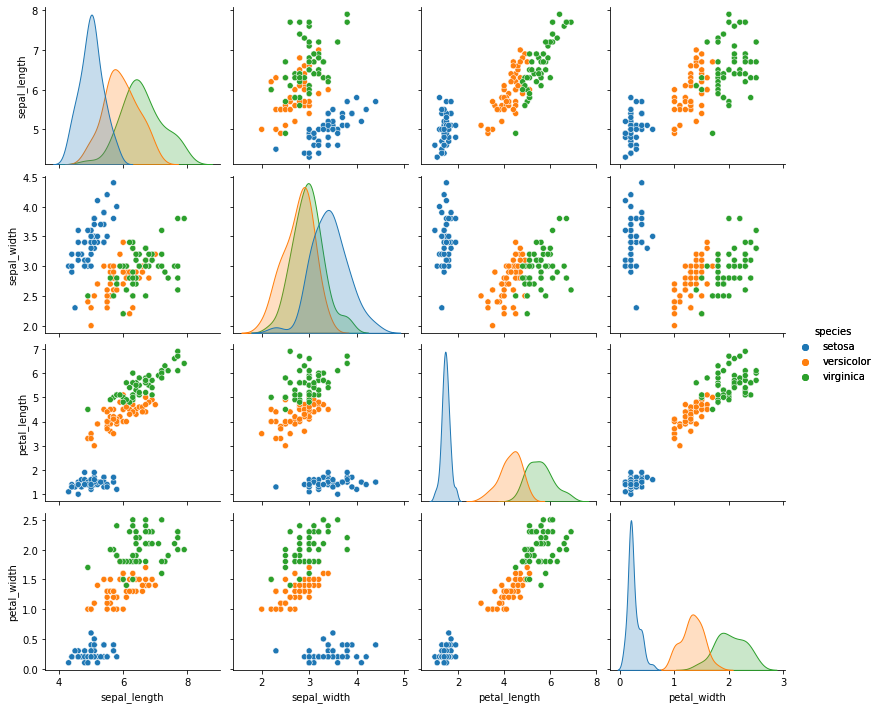

In [8]:
sns.pairplot(dataset[["sepal_length","sepal_width","petal_length","petal_width","species"]], hue = "species") \
.add_legend()

In [9]:
input_columns_all = torch.from_numpy(dataset[list(dataset.columns)[:-2]].to_numpy()).type(torch.float32)
input_columns = torch.from_numpy(dataset[['petal_length', 'petal_width']].to_numpy()).type(torch.float32)
output_columns = torch.tensor(dataset['species_index'])

print("Input columns all: ", input_columns_all.shape, input_columns_all.dtype)
print("Input columns: ", input_columns.shape, input_columns.dtype)
print("Output columns: ", output_columns.shape, output_columns.dtype)

Input columns all:  torch.Size([150, 4]) torch.float32
Input columns:  torch.Size([150, 2]) torch.float32
Output columns:  torch.Size([150]) torch.int64


In [11]:
data = TensorDataset(input_columns, output_columns)

In [12]:
split = 0.1
rows = list(input_columns.shape)[0]
test_split = int(rows*split)
val_split = int(rows*split*2)
train_split = rows - val_split - test_split

train_set, val_set, test_set = random_split(data, [train_split, val_split, test_split])

In [13]:
train_loader = DataLoader(train_set, 16, shuffle = True) #batch size = 16
val_loader = DataLoader(val_set) #batch size = 1
test_loader = DataLoader(test_set) #batch size = 1

In [15]:
class IrisModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 8)
        self.drop = nn.Dropout(0.1)
        self.linear2 = nn.Linear(8, output_size)

    def forward(self, x):
        x1 = self.linear1(x)
        x2 = self.drop(x1)
        outputs = self.linear2(x2)
        return outputs

    def training_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        _, pred = torch.max(outputs, 1)
        accuracy = torch.tensor(torch.sum(pred==targets).item()/len(pred))
        return [loss.detach(), accuracy.detach()] 

In [16]:
def evaluate(model, loader):
    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return loss, accuracy

In [18]:
model = IrisModel(2, 3)
loss, accuracy = evaluate(model, val_loader)
print("loss: ", loss.item(), "accuracy: ", accuracy.item())

loss:  1.0879265069961548 accuracy:  0.6666666865348816


In [19]:
def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = {"loss" : [], "accuracy" : []}
    optimizer = optimizer_function(model.parameters(), lr)
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validate
        for batch in val_loader:
            loss, accuracy = evaluate(model, val_loader)
        print("loss: ", loss.item(), "accuracy: ", accuracy.item(), "\n")
        history["loss"].append(loss.item())
        history["accuracy"].append(accuracy.item())
         
    return history

In [20]:
model = IrisModel(2, 3) # 2 input features and 3 output categories
history = fit(model, train_loader, val_loader, 16, 0.01)
loss, accuracy = evaluate(model, test_loader)
print("Evaluation result: Loss: ", loss.item(), " Accuracy: ", accuracy.item())


Epoch  0
loss:  1.1121113300323486 accuracy:  0.3333333432674408 

Epoch  1
loss:  1.1192965507507324 accuracy:  0.36666667461395264 

Epoch  2
loss:  1.0300354957580566 accuracy:  0.36666667461395264 

Epoch  3
loss:  0.8953968286514282 accuracy:  0.4000000059604645 

Epoch  4
loss:  0.8461360931396484 accuracy:  0.6333333253860474 

Epoch  5
loss:  0.761567234992981 accuracy:  0.7333333492279053 

Epoch  6
loss:  0.7437166571617126 accuracy:  0.800000011920929 

Epoch  7
loss:  0.6268532276153564 accuracy:  0.8666666746139526 

Epoch  8
loss:  0.616478681564331 accuracy:  0.8999999761581421 

Epoch  9
loss:  0.5109443068504333 accuracy:  0.8999999761581421 

Epoch  10
loss:  0.5063025951385498 accuracy:  0.8999999761581421 

Epoch  11
loss:  0.47778624296188354 accuracy:  0.8666666746139526 

Epoch  12
loss:  0.43650373816490173 accuracy:  0.800000011920929 

Epoch  13
loss:  0.40849196910858154 accuracy:  0.800000011920929 

Epoch  14
loss:  0.3981253206729889 accuracy:  0.833333313

Model with all input features

In [ ]:
data_all = TensorDataset(input_columns_all, output_columns)

#train_split, val_split and test_split defined earlier
train_set_all, val_set_all, test_set_all = random_split(data_all, [train_split, val_split, test_split])

train_loader_all = DataLoader(train_set_all, 16, shuffle = True)
val_loader_all = DataLoader(val_set_all)
test_loader_all = DataLoader(test_set_all)

model_all = IrisModel(4, 3)
history_all = fit(model_all, train_loader_all, val_loader_all, 16, 0.01)
loss , accuracy = evaluate(model_all, test_loader_all)
print("Evaluation result: Loss: ", loss.item(), " Accuracy: ", accuracy.item())

Epoch  0
loss:  1.0663504600524902 accuracy:  0.36666667461395264 

Epoch  1
loss:  0.9023124575614929 accuracy:  0.4000000059604645 

Epoch  2
loss:  0.676594078540802 accuracy:  0.9666666388511658 

Epoch  3
loss:  0.6933870315551758 accuracy:  0.8666666746139526 

Epoch  4
loss:  0.631925642490387 accuracy:  0.7333333492279053 

Epoch  5
loss:  0.6261173486709595 accuracy:  0.6000000238418579 

Epoch  6
loss:  0.5612112283706665 accuracy:  0.8666666746139526 

Epoch  7
